<a href="https://colab.research.google.com/github/kingdraw69/class-ciencia-de-datos/blob/main/analisisRUZI.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Preparación de Datos



PUUID
BG6NIIfqxWEfT5VNy7Jl2t7CWEP8EXuK2NGTnbuJh-wRssTi2Z-lOYWWwFYj5Fij5jvhMTV82tligA

In [ ]:
pip install requests

Obtener IDs


In [ ]:
# Obtener IDs de partidas competitivas solo/duo

import requests

API_KEY = "RGAPI-b8e826db-6a86-4334-ae1e-5d58daf4ce42"
PUUID = "BG6NIIfqxWEfT5VNy7Jl2t7CWEP8EXuK2NGTnbuJh-wRssTi2Z-lOYWWwFYj5Fij5jvhMTV82tligA"
REGION = "americas"


url = f"https://{REGION}.api.riotgames.com/lol/match/v5/matches/by-puuid/{PUUID}/ids?queue=420&count=20"
headers = {"X-Riot-Token": API_KEY}

try:
    response = requests.get(url, headers=headers)
    response.raise_for_status()
    match_ids = response.json()
    print("Solo/Duo Match IDs:", match_ids)
except requests.exceptions.RequestException as e:
    print("Error fetching match IDs:", e)

Solo/Duo Match IDs: ['LA1_1608899387', 'LA1_1608885984', 'LA1_1606761683', 'LA1_1606747692', 'LA1_1606643513', 'LA1_1606633950', 'LA1_1606631488', 'LA1_1606558585', 'LA1_1606382208', 'LA1_1606371478', 'LA1_1605898801', 'LA1_1605882891', 'LA1_1605875115', 'LA1_1605861519', 'LA1_1605850431', 'LA1_1605671883', 'LA1_1605370046', 'LA1_1605359492', 'LA1_1605343126', 'LA1_1605314780']


In [ ]:
from google.colab import files

with open("mi_archivo.txt", "w") as f:
    f.write("\n".join(match_ids))

Descargar json

In [ ]:
import requests
import json
import time

match_data_list = []

for match_id in match_ids:
    url = f"https://{REGION}.api.riotgames.com/lol/match/v5/matches/{match_id}"
    headers = {"X-Riot-Token": API_KEY}

    try:
        response = requests.get(url, headers=headers)
        response.raise_for_status()  # Check for errors
        match_data = response.json()
        match_data_list.append(match_data)
        print(f"Downloaded match: {match_id}")


        time.sleep(1.2)

    except requests.exceptions.RequestException as e:
        print(f"Failed to fetch {match_id}: {e}")

print(f"Total matches downloaded: {len(match_data_list)}")

Downloaded match: LA1_1608899387
Downloaded match: LA1_1608885984
Downloaded match: LA1_1606761683
Downloaded match: LA1_1606747692
Downloaded match: LA1_1606643513
Downloaded match: LA1_1606633950
Downloaded match: LA1_1606631488
Downloaded match: LA1_1606558585
Downloaded match: LA1_1606382208
Downloaded match: LA1_1606371478
Downloaded match: LA1_1605898801
Downloaded match: LA1_1605882891
Downloaded match: LA1_1605875115
Downloaded match: LA1_1605861519
Downloaded match: LA1_1605850431
Downloaded match: LA1_1605671883
Downloaded match: LA1_1605370046
Downloaded match: LA1_1605359492
Downloaded match: LA1_1605343126
Downloaded match: LA1_1605314780
Total matches downloaded: 20


In [ ]:
import os

os.makedirs("match_data", exist_ok=True)

for match in match_data_list:
    match_id = match["metadata"]["matchId"]
    with open(f"match_data/{match_id}.json", 'w') as f:
        json.dump(match, f)

In [ ]:
import os
import json
import pandas as pd
from pandas import json_normalize

os.makedirs("flattened_csv", exist_ok=True)

def flatten_match(json_file):
    """Fully flatten a match JSON file, preserving all fields."""
    with open(json_file, 'r') as f:
        data = json.load(f)

    metadata_df = json_normalize(data["metadata"])

    participants_df = json_normalize(data["info"]["participants"])
    participants_df["match_id"] = data["metadata"]["matchId"]


    teams_df = json_normalize(data["info"]["teams"])
    teams_df["match_id"] = data["metadata"]["matchId"]

    return metadata_df, participants_df, teams_df


all_metadata = []
all_participants = []
all_teams = []

for filename in os.listdir("match_data"):
    if filename.endswith(".json"):
        json_path = os.path.join("match_data", filename)
        metadata_df, participants_df, teams_df = flatten_match(json_path)
        all_metadata.append(metadata_df)
        all_participants.append(participants_df)
        all_teams.append(teams_df)


metadata_combined = pd.concat(all_metadata, ignore_index=True)
participants_combined = pd.concat(all_participants, ignore_index=True)
teams_combined = pd.concat(all_teams, ignore_index=True)


metadata_combined.to_csv("flattened_csv/metadata.csv", index=False)
participants_combined.to_csv("flattened_csv/participants.csv", index=False)
teams_combined.to_csv("flattened_csv/teams.csv", index=False)

print("Flattened CSVs saved in 'flattened_csv' folder!")

Flattened CSVs saved in 'flattened_csv' folder!


In [ ]:
import os
import json
import pandas as pd
from google.colab import files

os.makedirs("flattened_csv", exist_ok=True)

def flatten_match(json_file):
    """Flatten all nested fields in a match JSON and save as CSV."""
    with open(json_file, 'r') as f:
        try:
            data = json.load(f)
        except json.JSONDecodeError:
            print(f"Invalid JSON: {json_file}")
            return None

    if "metadata" not in data or "info" not in data:
        print(f"Skipping {json_file}: missing metadata/info")
        return None

    match_id = data["metadata"].get("matchId", "unknown")

    participants = data.get("info", {}).get("participants", [])
    if not participants:
        print(f"Skipping {match_id}: no participants data")
        return None

    try:
        df = pd.json_normalize(
            data,
            record_path=["info", "participants"],
            meta=[
                ["metadata", "matchId"],
                ["info", "gameDuration"],
                ["info", "queueId"]
            ],
            sep="_",
            errors="ignore"
        )
    except Exception as e:
        print(f"Failed to normalize {match_id}: {str(e)}")
        return None

    csv_path = f"flattened_csv/{match_id}.csv"
    df.to_csv(csv_path, index=False)
    print(f"Saved: {csv_path}")
    return df

for filename in os.listdir("match_data"):
    if filename.endswith(".json"):
        json_path = os.path.join("match_data", filename)
        flatten_match(json_path)

print("Processing complete!")

Saved: flattened_csv/LA1_1605875115.csv
Saved: flattened_csv/LA1_1605898801.csv
Saved: flattened_csv/LA1_1606631488.csv
Saved: flattened_csv/LA1_1605671883.csv
Saved: flattened_csv/LA1_1608899387.csv
Saved: flattened_csv/LA1_1605370046.csv
Saved: flattened_csv/LA1_1605343126.csv
Saved: flattened_csv/LA1_1605861519.csv
Saved: flattened_csv/LA1_1606371478.csv
Saved: flattened_csv/LA1_1606761683.csv
Saved: flattened_csv/LA1_1605359492.csv
Saved: flattened_csv/LA1_1605314780.csv
Saved: flattened_csv/LA1_1608885984.csv
Saved: flattened_csv/LA1_1606558585.csv
Saved: flattened_csv/LA1_1606633950.csv
Saved: flattened_csv/LA1_1606747692.csv
Saved: flattened_csv/LA1_1605882891.csv
Saved: flattened_csv/LA1_1606643513.csv
Saved: flattened_csv/LA1_1605850431.csv
Saved: flattened_csv/LA1_1606382208.csv
Processing complete!


Combinar todos los CSV obtenidos en un unico csv, que contenga la Información de las 20 partidas

In [ ]:
import os
import pandas as pd
from google.colab import files

TARGET_PUUID = "BG6NIIfqxWEfT5VNy7Jl2t7CWEP8EXuK2NGTnbuJh-wRssTi2Z-lOYWWwFYj5Fij5jvhMTV82tligA"

matching_rows = []

for csv_file in os.listdir("flattened_csv"):
    if csv_file.endswith(".csv"):
        csv_path = os.path.join("flattened_csv", csv_file)

        try:
            df = pd.read_csv(csv_path)

            if "puuid" in df.columns:
                matched_row = df[df["puuid"] == TARGET_PUUID]

                if not matched_row.empty:
                    matching_rows.append(matched_row)
                    print(f"Found match in: {csv_file}")
            else:
                print(f"Skipping {csv_file}: 'puuid' column missing")

        except Exception as e:
            print(f"Error de lectura {csv_file}: {e}")

if matching_rows:
    combined_df = pd.concat(matching_rows, ignore_index=True)

    output_path = "target_player_matches.csv"
    combined_df.to_csv(output_path, index=False)
    print(f"\nCombined {len(combined_df)} matches into: {output_path}")

Found match in: LA1_1605898801.csv
Found match in: LA1_1605850431.csv
Found match in: LA1_1605359492.csv
Found match in: LA1_1606631488.csv
Found match in: LA1_1605882891.csv
Found match in: participants.csv
Skipping metadata.csv: 'puuid' column missing
Found match in: LA1_1605370046.csv
Skipping teams.csv: 'puuid' column missing
Found match in: LA1_1605875115.csv
Found match in: LA1_1606633950.csv
Found match in: LA1_1606371478.csv
Found match in: LA1_1605861519.csv
Found match in: LA1_1606558585.csv
Found match in: LA1_1605671883.csv
Found match in: LA1_1608885984.csv
Found match in: LA1_1605314780.csv
Found match in: LA1_1606761683.csv
Found match in: LA1_1606382208.csv
Found match in: LA1_1606747692.csv
Found match in: LA1_1608899387.csv
Found match in: LA1_1605343126.csv
Found match in: LA1_1606643513.csv

Combined 40 matches into: target_player_matches.csv


# Preparación de Datos - timeline


In [ ]:
pip install requests

Encontrar y guardar json

In [ ]:
import os
import json
import requests
import pandas as pd
from google.colab import files


os.makedirs("timeline_json", exist_ok=True)
os.makedirs("timeline_csv", exist_ok=True)

def fetch_timeline(match_id):
    """Fetch and save timeline JSON for a match ID."""
    url = f"https://{REGION}.api.riotgames.com/lol/match/v5/matches/{match_id}/timeline"
    headers = {"X-Riot-Token": API_KEY}

    try:
        response = requests.get(url, headers=headers)
        response.raise_for_status()
        timeline_data = response.json()

        json_path = f"timeline_json/{match_id}.json"
        with open(json_path, 'w') as f:
            json.dump(timeline_data, f)
        print(f"Saved timeline JSON: {json_path}")
        return timeline_data

    except Exception as e:
        print(f"Failed to fetch timeline for {match_id}: {str(e)}")
        return None

for i, match_id in enumerate(match_ids):
    fetch_timeline(match_id)
    if (i + 1) % 90 == 0:
        time.sleep(120)
    else:
        time.sleep(1.2)

Saved timeline JSON: timeline_json/LA1_1608899387.json
Saved timeline JSON: timeline_json/LA1_1608885984.json
Saved timeline JSON: timeline_json/LA1_1606761683.json
Saved timeline JSON: timeline_json/LA1_1606747692.json
Saved timeline JSON: timeline_json/LA1_1606643513.json
Saved timeline JSON: timeline_json/LA1_1606633950.json
Saved timeline JSON: timeline_json/LA1_1606631488.json
Saved timeline JSON: timeline_json/LA1_1606558585.json
Saved timeline JSON: timeline_json/LA1_1606382208.json
Saved timeline JSON: timeline_json/LA1_1606371478.json
Saved timeline JSON: timeline_json/LA1_1605898801.json
Saved timeline JSON: timeline_json/LA1_1605882891.json
Saved timeline JSON: timeline_json/LA1_1605875115.json
Saved timeline JSON: timeline_json/LA1_1605861519.json
Saved timeline JSON: timeline_json/LA1_1605850431.json
Saved timeline JSON: timeline_json/LA1_1605671883.json
Saved timeline JSON: timeline_json/LA1_1605370046.json
Saved timeline JSON: timeline_json/LA1_1605359492.json
Saved time

JSON a CSV

In [ ]:
import os
import json
import pandas as pd
from google.colab import files

os.makedirs("timeline_csv_with_puuid", exist_ok=True)

def transform_timeline_with_puuid(json_file):
    """Convert timeline JSON to long-format CSV with PUUIDs."""
    with open(json_file, 'r') as f:
        data = json.load(f)

    match_id = data["metadata"]["matchId"]
    rows = []

    puuid_map = {
        str(participant["participantId"]): participant["puuid"]
        for participant in data["info"]["participants"]
    }

    for frame in data["info"]["frames"]:
        timestamp = frame["timestamp"]

        for participant_id, stats in frame["participantFrames"].items():
            rows.append({
                "match_id": match_id,
                "puuid": puuid_map[participant_id],
                "participant_id": participant_id,
                "timestamp": timestamp,
                "type": "participant_frame",
                **stats
            })

        for event in frame.get("events", []):
            event_row = {
                "match_id": match_id,
                "timestamp": event["timestamp"],
                "type": event["type"],
                "event_type": event["type"]
            }

            for id_field in ["killerId", "victimId", "creatorId", "participantId"]:
                if id_field in event:
                    event_row[f"{id_field}_puuid"] = puuid_map.get(str(event[id_field]))

            rows.append({**event_row, **event})

    df = pd.json_normalize(rows, sep="_")

    csv_path = f"timeline_csv_with_puuid/{match_id}_timeline.csv"
    df.to_csv(csv_path, index=False)
    print(f"Saved: {csv_path}")
    return df

for filename in os.listdir("timeline_json"):
    if filename.endswith(".json"):
        json_path = os.path.join("timeline_json", filename)
        transform_timeline_with_puuid(json_path)

print("All timelines processed with PUUIDs!")

Saved: timeline_csv_with_puuid/LA1_1605875115_timeline.csv
Saved: timeline_csv_with_puuid/LA1_1605898801_timeline.csv
Saved: timeline_csv_with_puuid/LA1_1606631488_timeline.csv
Saved: timeline_csv_with_puuid/LA1_1605671883_timeline.csv
Saved: timeline_csv_with_puuid/LA1_1608899387_timeline.csv
Saved: timeline_csv_with_puuid/LA1_1605370046_timeline.csv
Saved: timeline_csv_with_puuid/LA1_1605343126_timeline.csv
Saved: timeline_csv_with_puuid/LA1_1605861519_timeline.csv
Saved: timeline_csv_with_puuid/LA1_1606371478_timeline.csv
Saved: timeline_csv_with_puuid/LA1_1606761683_timeline.csv
Saved: timeline_csv_with_puuid/LA1_1605359492_timeline.csv
Saved: timeline_csv_with_puuid/LA1_1605314780_timeline.csv
Saved: timeline_csv_with_puuid/LA1_1608885984_timeline.csv
Saved: timeline_csv_with_puuid/LA1_1606558585_timeline.csv
Saved: timeline_csv_with_puuid/LA1_1606633950_timeline.csv
Saved: timeline_csv_with_puuid/LA1_1606747692_timeline.csv
Saved: timeline_csv_with_puuid/LA1_1605882891_timeline.c

Filtración de todos los CSV para que solo tengan información del jugador

In [ ]:
import os
import pandas as pd

TARGET_PUUID = "BG6NIIfqxWEfT5VNy7Jl2t7CWEP8EXuK2NGTnbuJh-wRssTi2Z-lOYWWwFYj5Fij5jvhMTV82tligA"
INPUT_FOLDER = "timeline_csv_with_puuid"
OUTPUT_FOLDER = "filtered_puuid_timelines"

os.makedirs(OUTPUT_FOLDER, exist_ok=True)

for filename in os.listdir(INPUT_FOLDER):
    if filename.endswith(".csv"):
        csv_path = os.path.join(INPUT_FOLDER, filename)

        df = pd.read_csv(csv_path)


        filtered_df = df[df['puuid'] == TARGET_PUUID]

        if not filtered_df.empty:
            output_path = os.path.join(OUTPUT_FOLDER, f"filtered_{filename}")
            filtered_df.to_csv(output_path, index=False)
            print(f"Saved filtered data: {output_path}")
        else:
            print(f"No matching rows found in: {filename}")

print("Filtering complete!")

Saved filtered data: filtered_puuid_timelines/filtered_LA1_1606558585_timeline.csv
Saved filtered data: filtered_puuid_timelines/filtered_LA1_1605861519_timeline.csv
Saved filtered data: filtered_puuid_timelines/filtered_LA1_1606633950_timeline.csv
Saved filtered data: filtered_puuid_timelines/filtered_LA1_1605875115_timeline.csv
Saved filtered data: filtered_puuid_timelines/filtered_LA1_1606761683_timeline.csv
Saved filtered data: filtered_puuid_timelines/filtered_LA1_1605314780_timeline.csv
Saved filtered data: filtered_puuid_timelines/filtered_LA1_1608885984_timeline.csv
Saved filtered data: filtered_puuid_timelines/filtered_LA1_1605850431_timeline.csv
Saved filtered data: filtered_puuid_timelines/filtered_LA1_1605370046_timeline.csv
Saved filtered data: filtered_puuid_timelines/filtered_LA1_1606747692_timeline.csv
Saved filtered data: filtered_puuid_timelines/filtered_LA1_1606643513_timeline.csv
Saved filtered data: filtered_puuid_timelines/filtered_LA1_1606631488_timeline.csv
Save

# Razón de victorias y derrotas



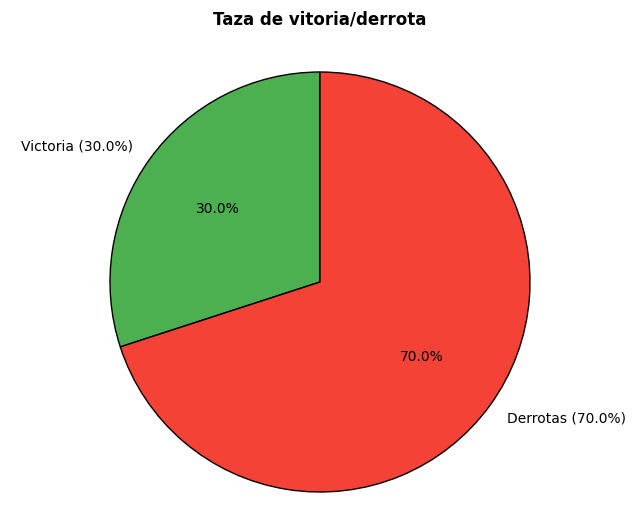

In [ ]:
import pandas as pd
import matplotlib.pyplot as plt

df = pd.read_csv("target_player_matches.csv")

win_count = df['win'].sum()
loss_count = len(df) - win_count
win_rate = (win_count / len(df)) * 100

plt.figure(figsize=(8, 6))
plt.pie(
    [win_count, loss_count],
    labels=[f'Victoria ({win_rate:.1f}%)', f'Derrotas ({100-win_rate:.1f}%)'],
    colors=['#4CAF50', '#F44336'],
    autopct='%1.1f%%',
    startangle=90,
    wedgeprops={'edgecolor': 'black', 'linewidth': 1}
)

plt.title('Taza de vitoria/derrota', pad=20, fontweight='bold')
plt.axis('equal')

plt.savefig('win_loss_pie.png', bbox_inches='tight', dpi=100)
plt.show()


# Campeones Usados y Rendimiento


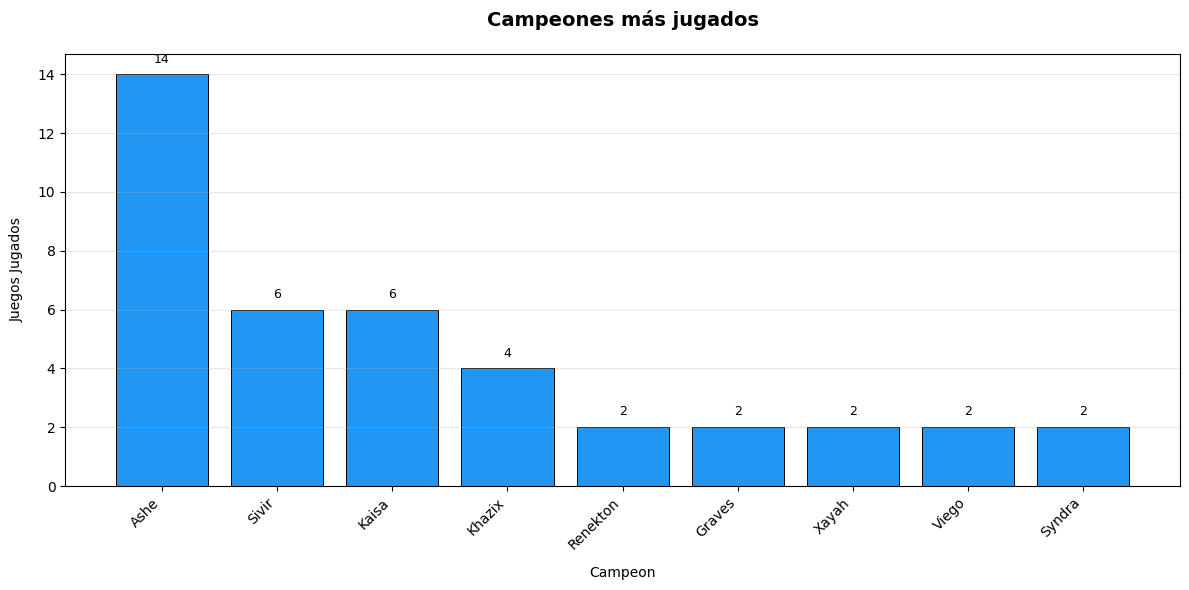

In [ ]:
import pandas as pd
import matplotlib.pyplot as plt

df = pd.read_csv("target_player_matches.csv")

# contar campeones y organizar
champ_counts = df['championName'].value_counts().sort_values(ascending=False)

# diagrama de barras
plt.figure(figsize=(12, 6))
bars = plt.bar(
    champ_counts.index,
    champ_counts.values,
    color='#2196F3',
    edgecolor='black',
    linewidth=0.7
)


for bar in bars:
    height = bar.get_height()
    plt.text(
        bar.get_x() + bar.get_width()/2.,
        height + 0.3,
        f'{int(height)}',
        ha='center',
        va='bottom',
        fontsize=9
    )


plt.title('Campeones más jugados', pad=20, fontweight='bold', fontsize=14)
plt.xlabel('Campeon', labelpad=10)
plt.ylabel('Juegos Jugados', labelpad=10)
plt.xticks(rotation=45, ha='right')
plt.grid(axis='y', alpha=0.3)


plt.tight_layout()


plt.savefig('champion_frequency.png', bbox_inches='tight', dpi=120)
plt.show()

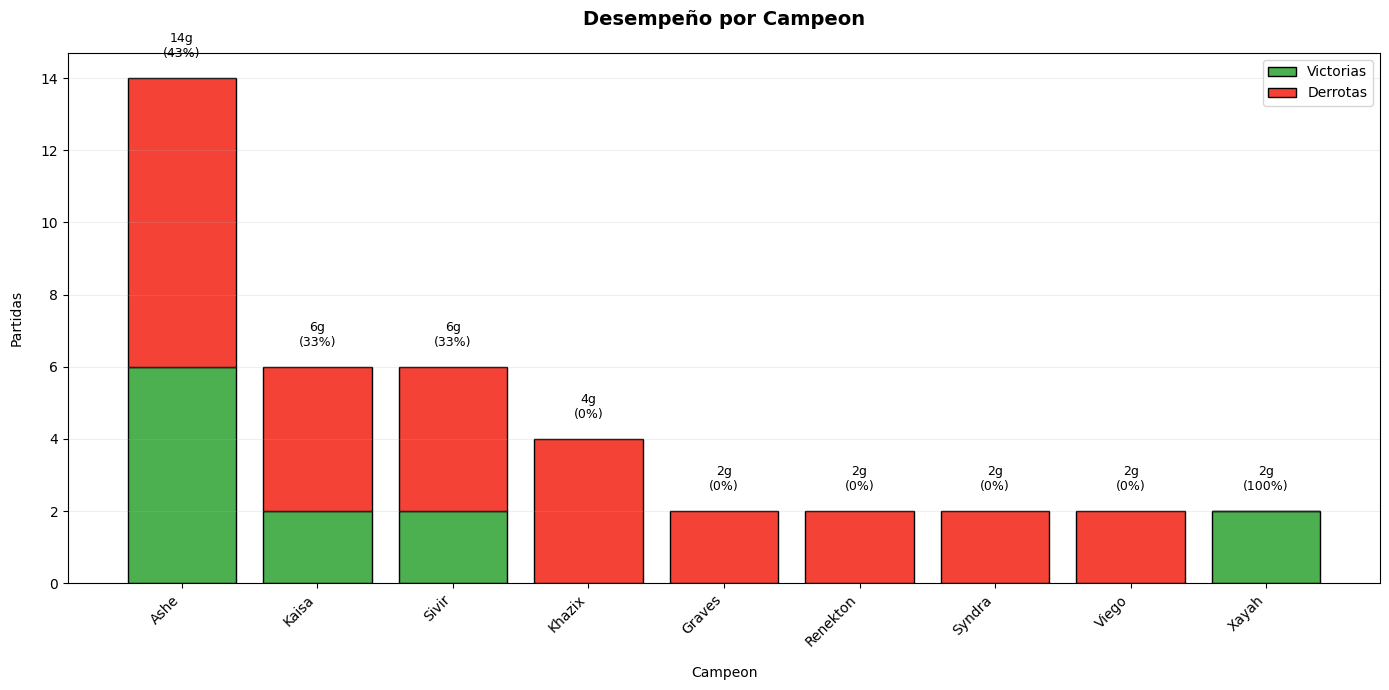

In [ ]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np


df = pd.read_csv("target_player_matches.csv")


champ_stats = df.groupby('championName').agg(
    total_games=('win', 'count'),
    wins=('win', 'sum')
).sort_values('total_games', ascending=False)

champ_stats['losses'] = champ_stats['total_games'] - champ_stats['wins']
champ_stats['win_rate'] = (champ_stats['wins'] / champ_stats['total_games']) * 100


plt.figure(figsize=(14, 7))


bars = plt.bar(
    champ_stats.index,
    champ_stats['wins'],
    color='#4CAF50',
    edgecolor='black',
    label='Victorias'
)

plt.bar(
    champ_stats.index,
    champ_stats['losses'],
    bottom=champ_stats['wins'],
    color='#F44336',
    edgecolor='black',
    label='Derrotas'
)


for i, champ in enumerate(champ_stats.index):
    total = champ_stats.loc[champ, 'total_games']
    win_rate = champ_stats.loc[champ, 'win_rate']


    plt.text(
        i,
        total + 0.5,
        f'{total}g\n({win_rate:.0f}%)',
        ha='center',
        va='bottom',
        fontsize=9
    )


plt.title('Desempeño por Campeon', pad=20, fontweight='bold', fontsize=14)
plt.xlabel('Campeon', labelpad=12)
plt.ylabel('Partidas', labelpad=12)
plt.xticks(rotation=45, ha='right')
plt.legend(loc='upper right')
plt.grid(axis='y', alpha=0.2)

plt.tight_layout()


plt.savefig('champion_performance.png', bbox_inches='tight', dpi=120)
plt.show()



KDA = (Kills+Assists)/Deaths

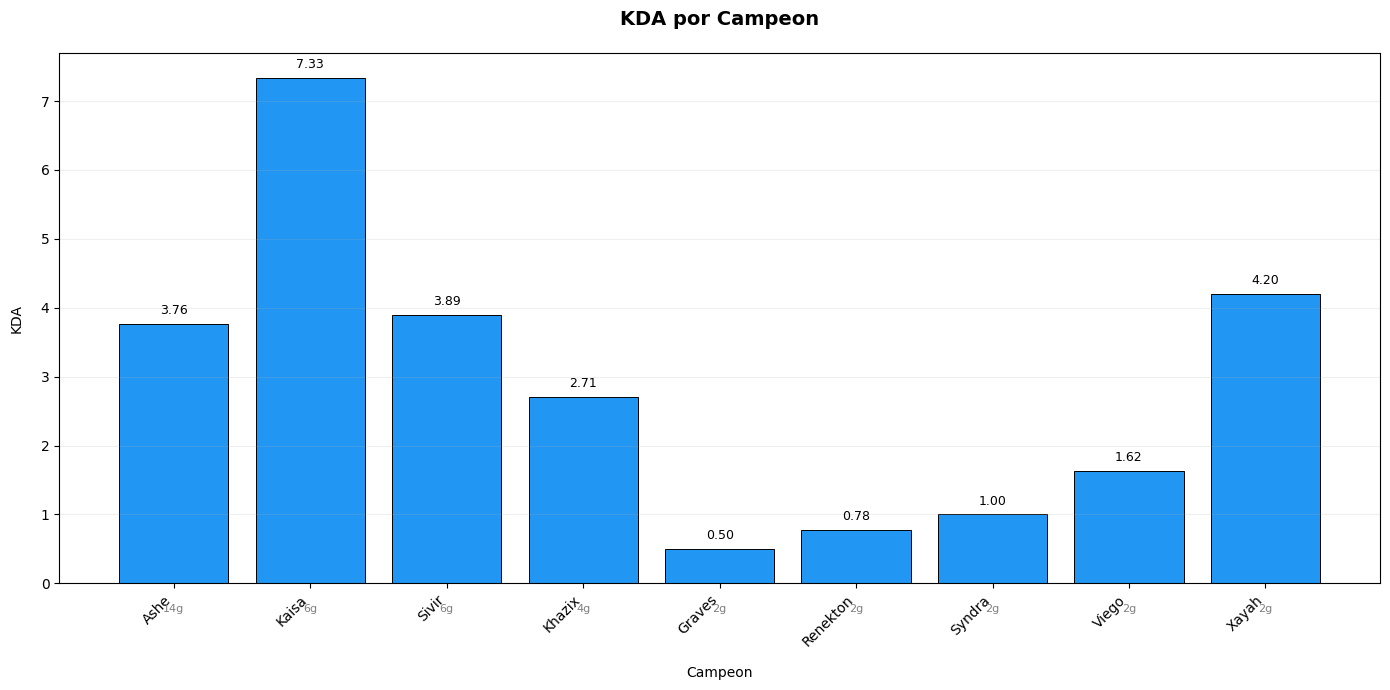

In [ ]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np

df = pd.read_csv("target_player_matches.csv")

df['KDA'] = (df['kills'] + df['assists']) / np.maximum(df['deaths'], 1)

champ_stats = df.groupby('championName').agg(
    total_games=('win', 'count'),
    avg_kills=('kills', 'mean'),
    avg_deaths=('deaths', 'mean'),
    avg_assists=('assists', 'mean'),
    avg_KDA=('KDA', 'mean')
).sort_values('total_games', ascending=False)

plt.figure(figsize=(14, 7))

bars = plt.bar(
    champ_stats.index,
    champ_stats['avg_KDA'],
    color='#2196F3',
    edgecolor='black',
    linewidth=0.7
)

for bar in bars:
    height = bar.get_height()
    plt.text(
        bar.get_x() + bar.get_width()/2.,
        height + 0.1,
        f'{height:.2f}',
        ha='center',
        va='bottom',
        fontsize=9
    )

for i, champ in enumerate(champ_stats.index):
    plt.text(
        i,
        -0.3,
        f"{int(champ_stats.loc[champ, 'total_games'])}g",
        ha='center',
        va='top',
        fontsize=8,
        color='gray'
    )

plt.title('KDA por Campeon', pad=20, fontweight='bold', fontsize=14)
plt.xlabel('Campeon', labelpad=12)
plt.ylabel('KDA', labelpad=12)
plt.xticks(rotation=45, ha='right')
plt.grid(axis='y', alpha=0.2)

plt.tight_layout()

plt.savefig('champion_kda.png', bbox_inches='tight', dpi=120)
plt.show()

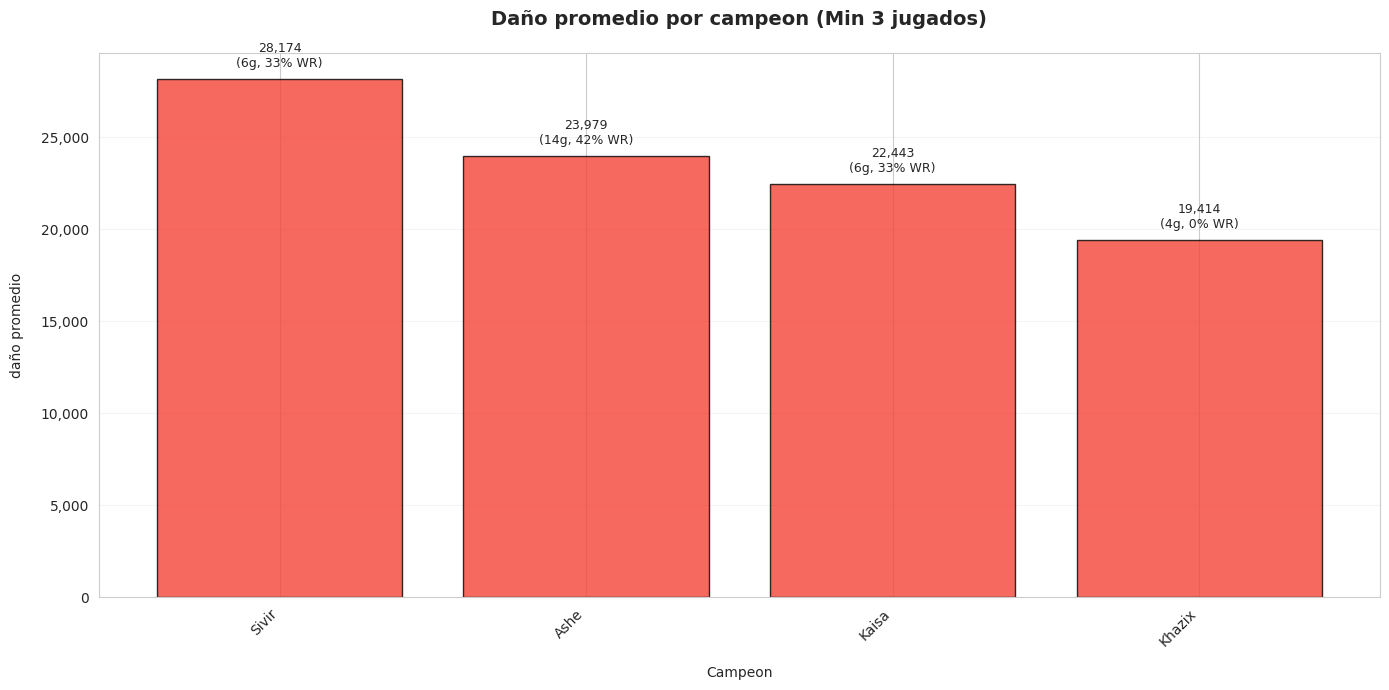

In [ ]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np

df = pd.read_csv("target_player_matches.csv")

damage_stats = df.groupby('championName').agg(
    avg_damage=('totalDamageDealtToChampions', 'mean'),
    games_played=('championName', 'count'),
    win_rate=('win', 'mean')
).sort_values('avg_damage', ascending=False)

min_games = 3
damage_stats = damage_stats[damage_stats['games_played'] >= min_games]

plt.figure(figsize=(14, 7))

colors = ['#4CAF50' if x > 0.5 else '#F44336' for x in damage_stats['win_rate']]
bars = plt.bar(
    damage_stats.index,
    damage_stats['avg_damage'],
    color=colors,
    edgecolor='black',
    alpha=0.8
)

for i, champ in enumerate(damage_stats.index):
    avg_dmg = int(damage_stats.loc[champ, 'avg_damage'])
    games = damage_stats.loc[champ, 'games_played']
    win_pct = int(damage_stats.loc[champ, 'win_rate'] * 100)

    plt.text(
        i,
        avg_dmg + 500,
        f'{avg_dmg:,}\n({games}g, {win_pct}% WR)',
        ha='center',
        va='bottom',
        fontsize=9
    )

plt.title(f'Daño promedio por campeon (Min {min_games} jugados)',
          pad=20, fontweight='bold', fontsize=14)
plt.xlabel('Campeon', labelpad=12)
plt.ylabel('daño promedio', labelpad=12)
plt.xticks(rotation=45, ha='right')

plt.gca().yaxis.set_major_formatter(plt.FuncFormatter(lambda x, _: f'{int(x):,}'))

plt.grid(axis='y', alpha=0.2)
plt.tight_layout()

plt.savefig('champion_damage.png', bbox_inches='tight', dpi=120)
plt.show()


# Correlación entre Datos y Victoria

nexusLost                             1.000000
win                                   1.000000
turretTakedowns                       0.902112
challenges.turretTakedowns            0.902112
challenges_turretTakedowns            0.902112
turretsLost                           0.896761
inhibitorTakedowns                    0.781527
damageDealtToTurrets                  0.775936
damageDealtToBuildings                0.775936
nexusTakedowns                        0.763763
challenges.goldPerMinute              0.741133
challenges_goldPerMinute              0.741133
largestKillingSpree                   0.705117
inhibitorsLost                        0.692574
challenges.kda                        0.674650
challenges_kda                        0.674650
turretKills                           0.674140
challenges_maxKillDeficit             0.654543
challenges.maxKillDeficit             0.654543
challenges_landSkillShotsEarlyGame    0.642073
Name: win, dtype: float64


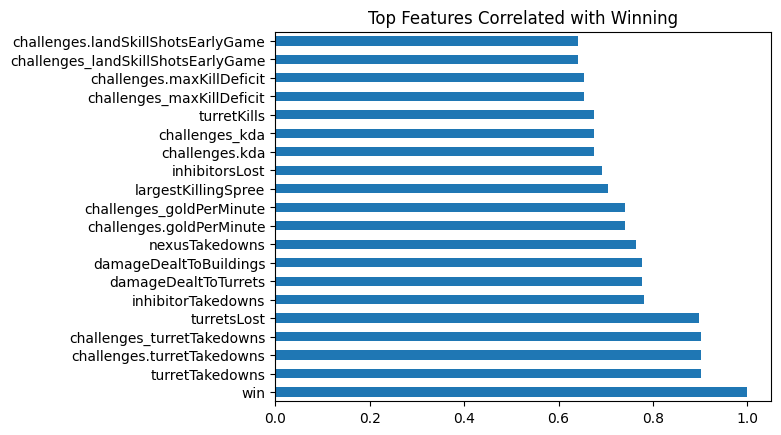

In [ ]:
import pandas as pd

win_corr = df.corr(numeric_only=True)['win'].abs().sort_values(ascending=False)

print(win_corr.head(20))

win_corr[1:21].plot.barh(title='Valores más correlacionados con la victoria');

In [ ]:
win_stats = df.groupby('win').mean(numeric_only=True).T
win_stats['impact'] = win_stats[True] - win_stats[False]

win_stats['abs_impact'] = win_stats['impact'].abs()
print(win_stats.sort_values('abs_impact', ascending=False).head(10))

win                              False           True        impact  \
physicalDamageDealt      143027.714286  174463.833333  31436.119048   
totalDamageDealt         175804.642857  191858.000000  16053.357143   
trueDamageDealt           20609.357143    6956.833333 -13652.523810   
totalDamageTaken          29544.142857   16266.666667 -13277.476190   
damageDealtToObjectives   11116.428571   23766.666667  12650.238095   
damageDealtToBuildings     1734.714286    9731.833333   7997.119048   
damageDealtToTurrets       1734.714286    9731.833333   7997.119048   
physicalDamageTaken       17421.857143    9809.166667  -7612.690476   
damageSelfMitigated       17523.285714   10099.833333  -7423.452381   
magicDamageTaken          10551.642857    5860.000000  -4691.642857   

win                        abs_impact  
physicalDamageDealt      31436.119048  
totalDamageDealt         16053.357143  
trueDamageDealt          13652.523810  
totalDamageTaken         13277.476190  
damageDealtToObjec

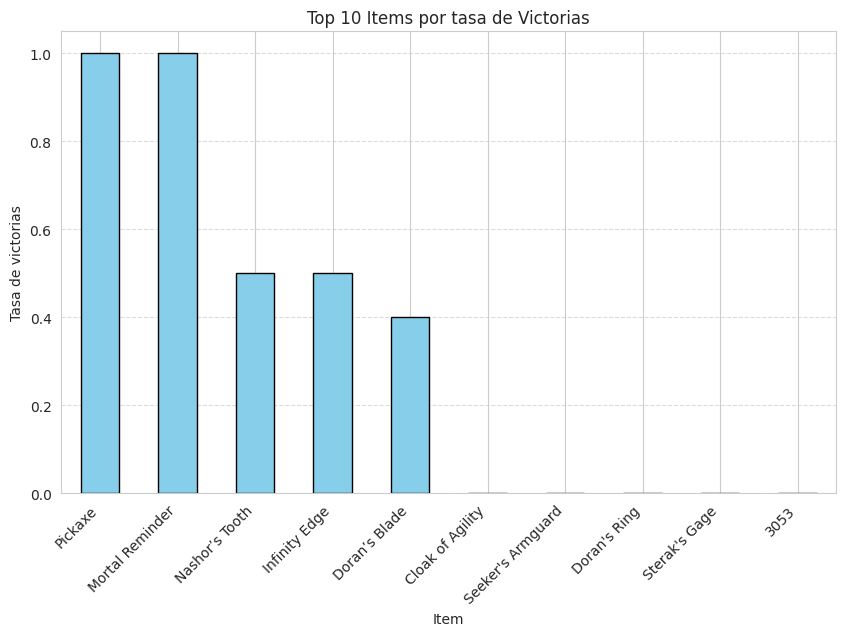


Correlación entre el total de objetos comprados y la victoria:  -0.06008674396393929

Correlación de cada slot de items para la victoria:
item0: -0.24906287285552392
item1: -0.4727974349825929
item2: 0.5849903146961377
item3: -0.058038184350909
item4: -0.00877056597821399
item5: 0.13065867464400735
item6: -0.16261994468169788


In [ ]:
import pandas as pd
import matplotlib.pyplot as plt

df['win'] = df['win'].astype(int)

item_names = {
    1037: "Pickaxe",
    3033: "Mortal Reminder",
    3031: "Infinity Edge",
    3115: "Nashor’s Tooth",
    1055: "Doran’s Blade",
    1018: "Cloak of Agility",
    2420: "Seeker's Armguard",
    1056: "Doran's Ring",
    3053: "Sterak's Gage",
    3036: "3053"
}

item_columns = [f'item{i}' for i in range(7)]

all_items = df.melt(value_vars=item_columns, var_name="item_slot", value_name="item_id")
win_rates = all_items.merge(df[['win']], left_index=True, right_index=True)\
                     .groupby("item_id")['win'].mean().sort_values(ascending=False)

win_rates_named = win_rates.rename(index=item_names).dropna()

plt.figure(figsize=(10, 6))
win_rates_named.head(10).plot(kind='bar', color='skyblue', edgecolor='black')
plt.xlabel("Item")
plt.ylabel("Tasa de victorias")
plt.title("Top 10 Items por tasa de Victorias")
plt.xticks(rotation=45, ha='right')
plt.grid(axis='y', linestyle='--', alpha=0.7)
plt.show()

correlation_total_items = df[['itemsPurchased', 'win']].corr().iloc[0, 1]

correlations_items = {col: df[[col, 'win']].corr().iloc[0, 1] for col in item_columns}

print("\nCorrelación entre el total de objetos comprados y la victoria: ", correlation_total_items)
print("\nCorrelación de cada slot de items para la victoria:")
for slot, corr in correlations_items.items():
    print(f"{slot}: {corr}")

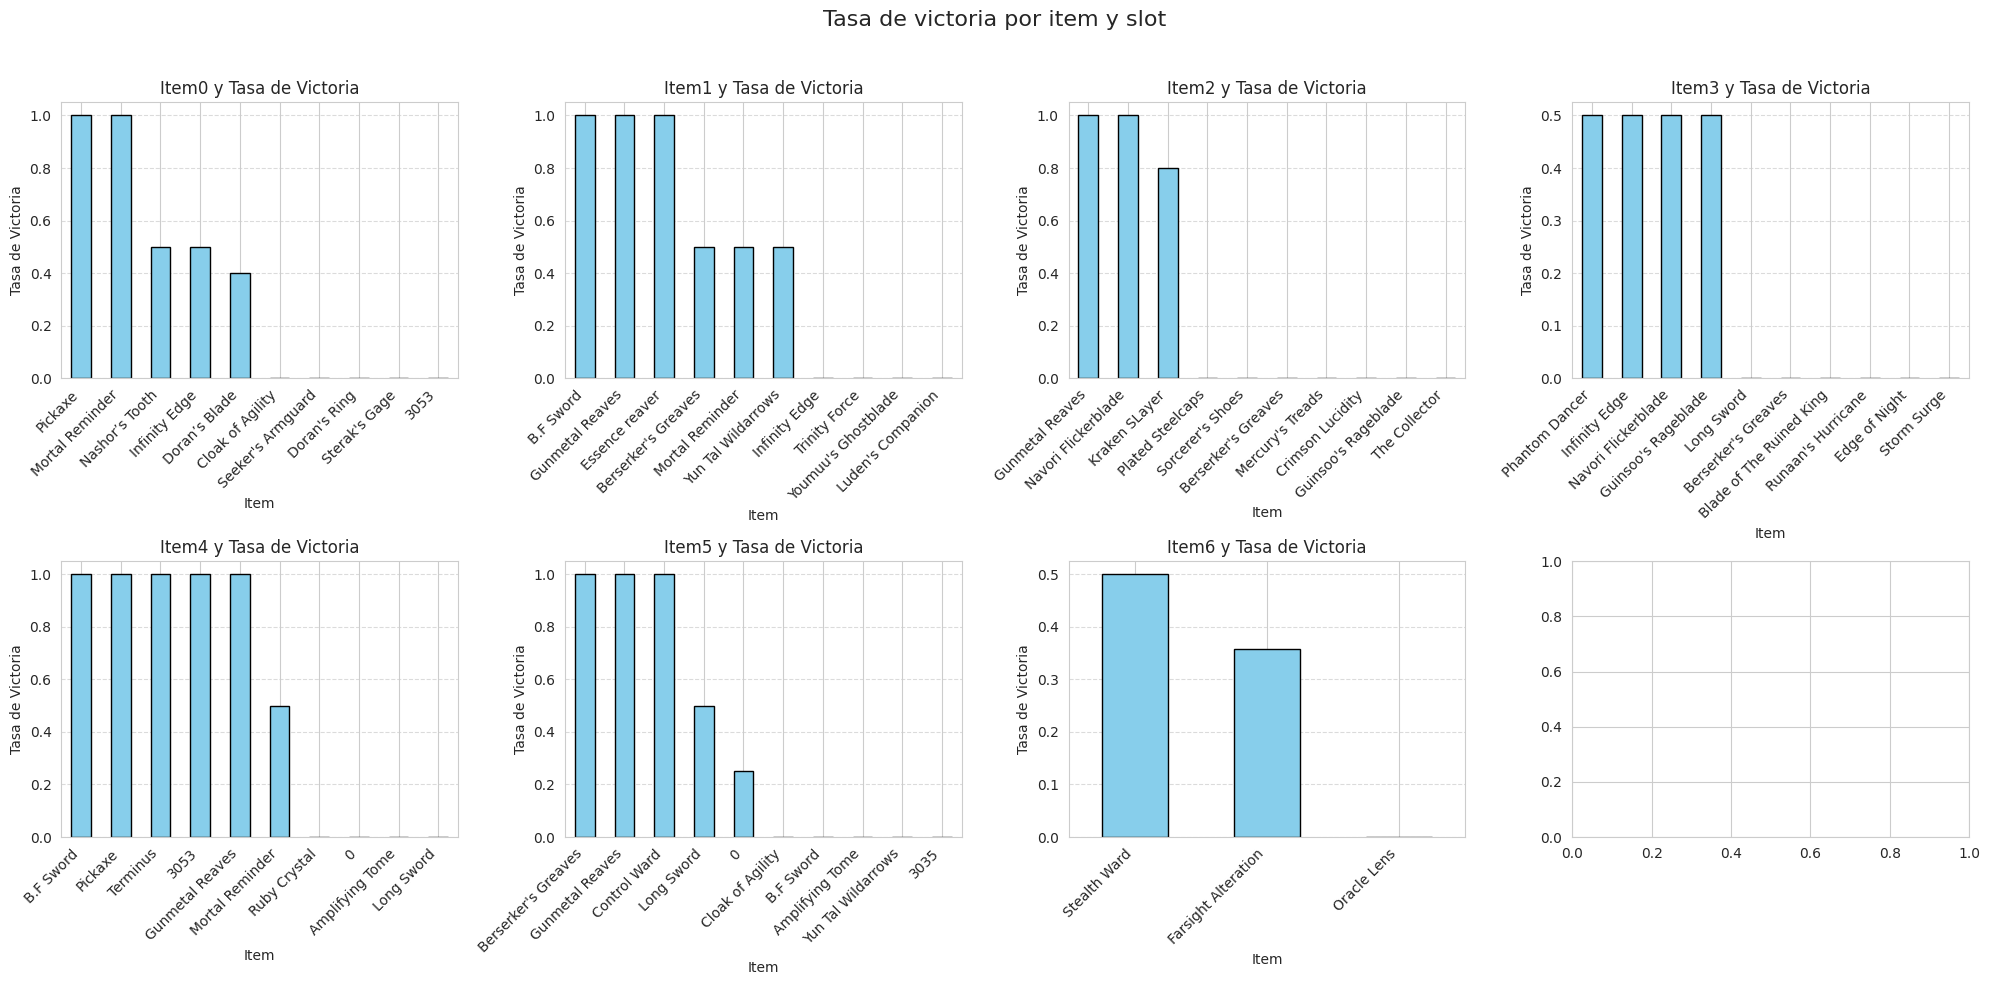


Correlación entre el total de objetos comprados y la victoria:  -0.06008674396393929

Correlación de cada slot de items para la victoria:
item0: -0.24906287285552392
item1: -0.4727974349825929
item2: 0.5849903146961377
item3: -0.058038184350909
item4: -0.00877056597821399
item5: 0.13065867464400735
item6: -0.16261994468169788


In [ ]:
import pandas as pd
import matplotlib.pyplot as plt

df['win'] = df['win'].astype(int)

item_names = {
    1037: "Pickaxe",
    3033: "Mortal Reminder",
    3031: "Infinity Edge",
    3115: "Nashor’s Tooth",
    1055: "Doran’s Blade",
    1018: "Cloak of Agility",
    2420: "Seeker's Armguard",
    1056: "Doran's Ring",
    3053: "Sterak's Gage",
    3036: "3053",
    1038: "B.F Sword",
    3172: "Gunmetal Reaves",
    3508: "Essence reaver",
    3032: "Yun Tal Wildarrows",
    3078: "Trinity Force",
    3142: "Youmuu's Ghostblade",
    6655: "Luden's Companion",
    3006: "Berserker's Greaves",
    6675: "Navori Flickerblade",
    6672: "Kraken SLayer",
    3047: "Plated Steelcaps",
    3020: "Sorcerer's Shoes",
    3111: "Mercury's Treads",
    3171: "Crimson Lucidity",
    3124: "Guinsoo's Rageblade",
    6676: "The Collector",
    3046: "Phantom Dancer",
    1036: "Long Sword",
    3153: "Blade of The Ruined King",
    3085: "Runaan's Hurricane",
    3814: "Edge of Night",
    4646: "Storm Surge",
    3302: "Terminus",
    3053: "Sterak's Gage",
    1028: "Ruby Crystal",
    1052: "Amplifying Tome",
    2055: "Control Ward",
    3340: "Stealth Ward",
    3363: "Farsight Alteration",
    3364: "Oracle Lens"
}
item_columns = [f'item{i}' for i in range(7)]

win_rates_per_slot = {}
for slot in item_columns:
    slot_win_rates = df.groupby(slot)['win'].mean().sort_values(ascending=False)
    win_rates_per_slot[slot] = slot_win_rates.rename(index=item_names).dropna()

fig, axes = plt.subplots(2, 4, figsize=(20, 10))
fig.suptitle("Tasa de victoria por item y slot", fontsize=16)
axes = axes.flatten()

for i, slot in enumerate(item_columns):
    ax = axes[i]
    win_rates_per_slot[slot].head(10).plot(kind='bar', color='skyblue', edgecolor='black', ax=ax)
    ax.set_title(f"{slot.capitalize()} y Tasa de Victoria")
    ax.set_xlabel("Item")
    ax.set_ylabel("Tasa de Victoria")
    ax.set_xticklabels(ax.get_xticklabels(), rotation=45, ha='right')
    ax.grid(axis='y', linestyle='--', alpha=0.7)

plt.tight_layout(rect=[0, 0, 1, 0.96])
plt.show()

# Correlation between total items purchased and win rate
correlation_total_items = df[['itemsPurchased', 'win']].corr().iloc[0, 1]

# Compute correlation of each item slot with win
correlations_items = {col: df[[col, 'win']].corr().iloc[0, 1] for col in item_columns}

# Display additional results
print("\nCorrelación entre el total de objetos comprados y la victoria: ", correlation_total_items)
print("\nCorrelación de cada slot de items para la victoria:")
for slot, corr in correlations_items.items():
    print(f"{slot}: {corr}")


# Analisis timeline

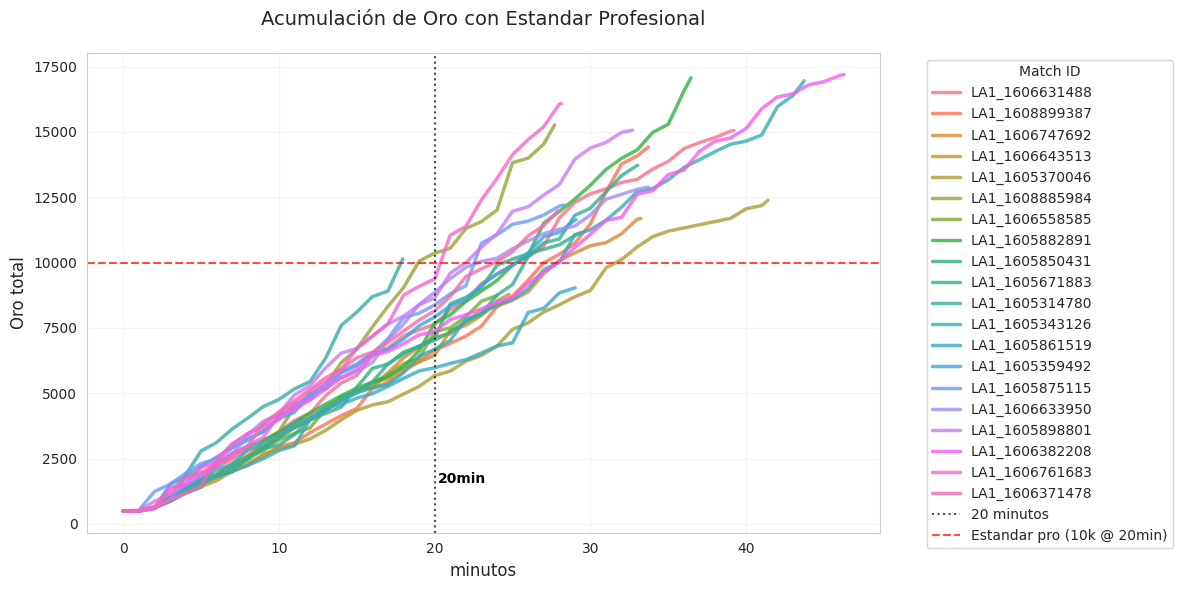

In [ ]:
import matplotlib.pyplot as plt
import seaborn as sns

sns.set_style("whitegrid")
plt.figure(figsize=(12, 6))

sns.lineplot(
    data=combined_df,
    x='game_minute',
    y='totalGold',
    hue='match_id',
    palette='husl',
    linewidth=2.5,
    alpha=0.8,
    estimator=None
)

plt.axvline(x=20, color='black', linestyle=':', linewidth=1.5,
            label='20 minutos', alpha=0.7)
plt.axhline(y=10000, color='red', linestyle='--', linewidth=1.5,
            label='Estandar pro (10k @ 20min)', alpha=0.7)

plt.text(20.2, combined_df['totalGold'].max()*0.1,
         '20min', rotation=0, va='center', color='black', fontweight='bold')

plt.title('Acumulación de Oro con Estandar Profesional', fontsize=14, pad=20)
plt.xlabel('minutos', fontsize=12)
plt.ylabel('Oro total', fontsize=12)
plt.legend(bbox_to_anchor=(1.05, 1), loc='upper left', title='Match ID')

# Add grid and adjust layout
plt.grid(True, alpha=0.2)
plt.tight_layout()
plt.show()

<ipython-input-50-326927c831ab>:2: DeprecationWarning:

DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.



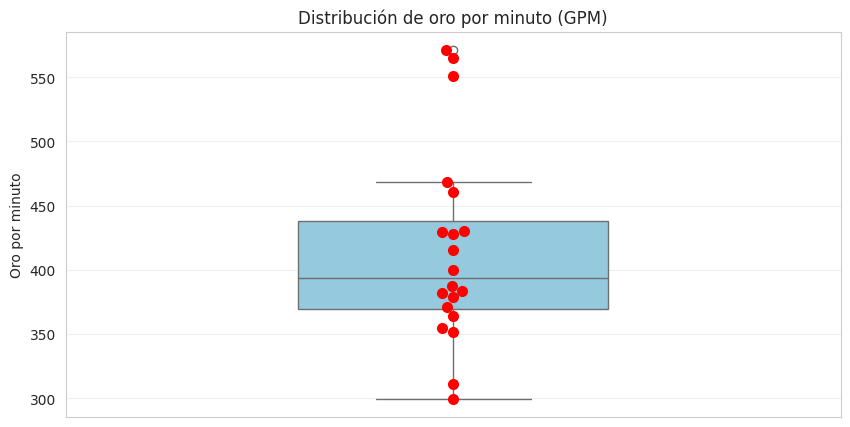

In [ ]:

gpm_stats = combined_df.groupby('match_id').apply(
    lambda x: x['totalGold'].max() / (x['timestamp'].max() / 60000)
).reset_index(name='GPM')

plt.figure(figsize=(10, 5))
sns.boxplot(data=gpm_stats, y='GPM', color='skyblue', width=0.4)
sns.swarmplot(data=gpm_stats, y='GPM', color='red', size=8)
plt.title('Distribución de oro por minuto (GPM)')
plt.ylabel('Oro por minuto')
plt.grid(axis='y', alpha=0.3)
plt.show()

In [ ]:

gold_sources = combined_df.groupby('match_id').agg({
    'minionsKilled': 'max',
    'jungleMinionsKilled': 'max',
    'totalGold': 'max'
}).reset_index()
gold_sources['minion_gold'] = gold_sources['minionsKilled'] * 21
gold_sources['jungle_gold'] = gold_sources['jungleMinionsKilled'] * 80

gold_sources.set_index('match_id')[['minion_gold', 'jungle_gold']].plot(
    kind='bar',
    stacked=True,
    figsize=(12, 6),
    color=['#2ecc71', '#e74c3c'],
    title='Fuentes de Oro por partida'
)
plt.ylabel('Total Gold')
plt.legend(['Minions', 'Jungle'])
plt.axhline(y=8000, color='blue', linestyle=':', label='Objetivo de oro por minions')
plt.grid(axis='y', alpha=0.3)
plt.show()

NameError: name 'combined_df' is not defined

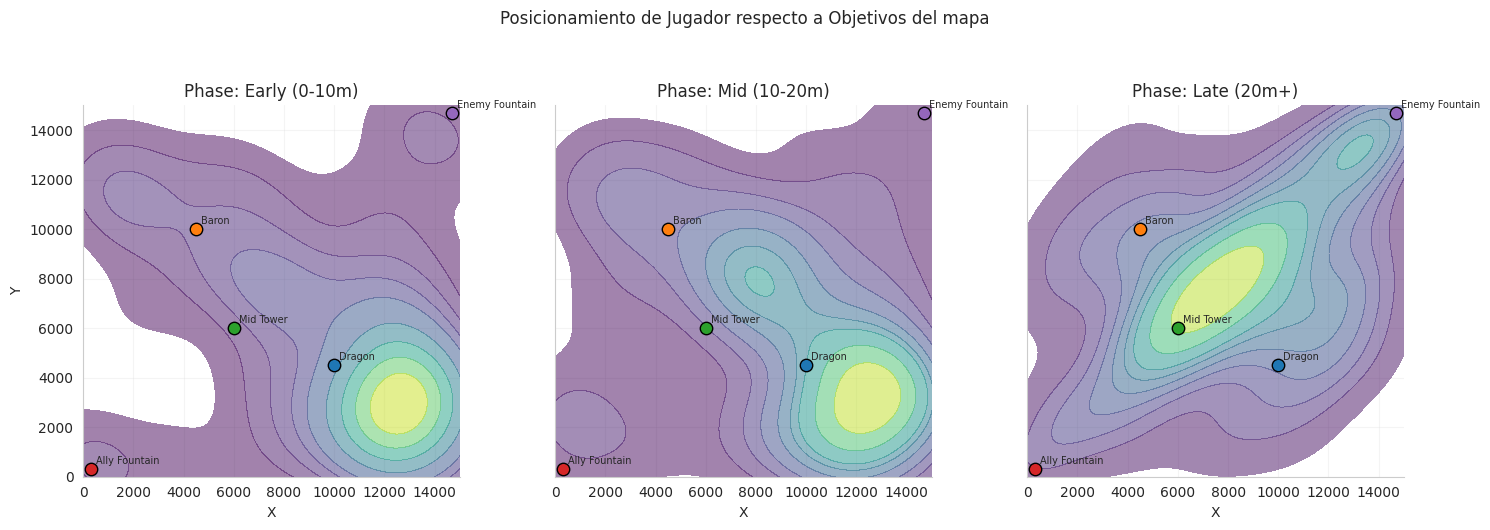

In [ ]:
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd


objectives = {
    'Dragon': (10000, 4500),
    'Baron': (4500, 10000),
    'Mid Tower': (6000, 6000),
    'Ally Fountain': (300, 300),
    'Enemy Fountain': (14700, 14700)
}


combined_df['game_phase'] = pd.cut(
    combined_df['timestamp'] / 60000,
    bins=[0, 10, 20, 40],
    labels=['Early (0-10m)', 'Mid (10-20m)', 'Late (20m+)']
)


g = sns.FacetGrid(
    combined_df,
    col='game_phase',
    col_order=['Early (0-10m)', 'Mid (10-20m)', 'Late (20m+)'],
    height=5,
    aspect=1,
    xlim=(0, 15000),
    ylim=(0, 15000)
)


g.map_dataframe(
    sns.kdeplot,
    x='position_x',
    y='position_y',
    cmap='viridis',
    fill=True,
    alpha=0.5,
    levels=10
)


for ax, phase in zip(g.axes.flat, g.col_names):
    for obj, (x, y) in objectives.items():
        ax.scatter(x, y, s=80, label=obj, edgecolor='black', linewidth=1)
        ax.text(x + 200, y + 200, obj, fontsize=7, ha='left')
    ax.set_title(f'Phase: {phase}')
    ax.grid(alpha=0.2)


g.set_axis_labels('X', 'Y')
g.fig.suptitle('Posicionamiento de Jugador respecto a Objetivos del mapa', y=1.05)
plt.tight_layout()
plt.show()